In [7]:
#PreProcessing
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler, LabelEncoder, OneHotEncoder,StandardScaler
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE, ADASYN, RandomOverSampler
import joblib
import warnings
warnings.filterwarnings('ignore')
#Feature Engineering
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.ensemble import ExtraTreesClassifier, RandomForestClassifier
from xgboost import XGBClassifier        # recommended for feature importance
from catboost import CatBoostClassifier  # optional alternative, handles categorical features natively
#visualization
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import MaxNLocator
from matplotlib.colors import ListedColormap
#clustering
import gower
import random
from sklearn.cluster import KMeans
from pyclustering.cluster.kmedoids import kmedoids
import matplotlib.pyplot as plt
from sklearn.metrics import adjusted_rand_score, silhouette_score, davies_bouldin_score, calinski_harabasz_score

In [3]:
df = pd.read_csv('C:/Users/Sultan/Downloads/ML/ML_Project/4. Credit Card/csv-files/0_credit.csv')

In [4]:
df.head()

,CUST_ID,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE
0,C10001,40.900749,0.818182,95.40,0.00,95.4,0.000000,0.166667,0.000000,0.083333,0.000000,0,2,1000.0,201.802084,139.509787,0.000000,12
1,C10002,3202.467416,0.909091,0.00,0.00,0.0,6442.945483,0.000000,0.000000,0.000000,0.250000,4,0,7000.0,4103.032597,1072.340217,0.222222,12
2,C10003,2495.148862,1.000000,773.17,773.17,0.0,0.000000,1.000000,1.000000,0.000000,0.000000,0,12,7500.0,622.066742,627.284787,0.000000,12
3,C10004,1666.670542,0.636364,1499.00,1499.00,0.0,205.788017,0.083333,0.083333,0.000000,0.083333,1,1,7500.0,0.000000,NaN,0.000000,12
4,C10005,817.714335,1.000000,16.00,16.00,0.0,0.000000,0.083333,0.083333,0.000000,0.000000,0,1,1200.0,678.334763,244.791237,0.000000,12


# Preprocessing

In [5]:
df = df.drop(['CUST_ID'],axis=1)

In [6]:
#finding outliers
min_max_values = df.aggregate(['min','max'])
print(min_max_values)

         BALANCE  BALANCE_FREQUENCY  PURCHASES  ONEOFF_PURCHASES  \
min      0.00000                0.0       0.00              0.00   
max  19043.13856                1.0   49039.57          40761.25   

     INSTALLMENTS_PURCHASES  CASH_ADVANCE  PURCHASES_FREQUENCY  \
min                     0.0       0.00000                  0.0   
max                 22500.0   47137.21176                  1.0   

     ONEOFF_PURCHASES_FREQUENCY  PURCHASES_INSTALLMENTS_FREQUENCY  \
min                         0.0                               0.0   
max                         1.0                               1.0   

     CASH_ADVANCE_FREQUENCY  CASH_ADVANCE_TRX  PURCHASES_TRX  CREDIT_LIMIT  \
min                     0.0                 0              0          50.0   
max                     1.5               123            358       30000.0   

        PAYMENTS  MINIMUM_PAYMENTS  PRC_FULL_PAYMENT  TENURE  
min      0.00000          0.019163               0.0       6  
max  50721.48336      76406

In [13]:
# Select only numeric columns
numeric_cols = df.select_dtypes(include=['float64','int64']).columns

# Dictionary to store outlier counts
outlier_summary = {}

for col in numeric_cols:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    
    # Count outliers
    outliers = df[(df[col] < lower) | (df[col] > upper)]
    outlier_summary[col] = len(outliers)

# Convert to DataFrame for readability
outlier_summary_df = pd.DataFrame.from_dict(outlier_summary, orient='index', columns=['Outlier Count'])

print(outlier_summary_df)


                                  Outlier Count
BALANCE                                     695
BALANCE_FREQUENCY                          1493
PURCHASES                                   808
ONEOFF_PURCHASES                           1013
INSTALLMENTS_PURCHASES                      867
CASH_ADVANCE                               1030
PURCHASES_FREQUENCY                           0
ONEOFF_PURCHASES_FREQUENCY                  782
PURCHASES_INSTALLMENTS_FREQUENCY              0
CASH_ADVANCE_FREQUENCY                      525
CASH_ADVANCE_TRX                            804
PURCHASES_TRX                               766
CREDIT_LIMIT                                248
PAYMENTS                                    808
MINIMUM_PAYMENTS                            841
PRC_FULL_PAYMENT                           1474
TENURE                                     1366


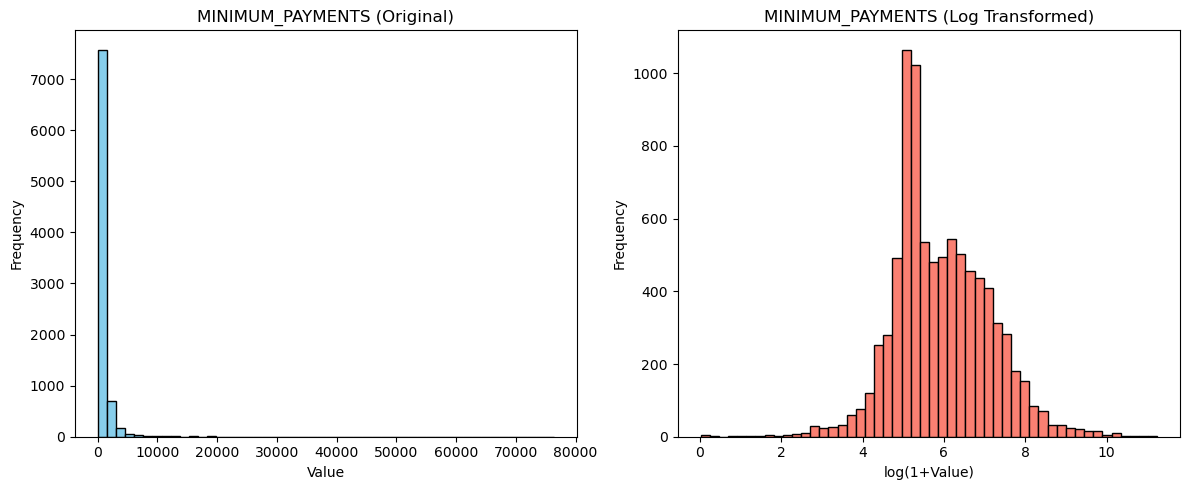

In [7]:

# Drop NA for plotting
mp = df["MINIMUM_PAYMENTS"].dropna()

# Apply log1p transform
mp_log = np.log1p(mp)

# Plot
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.hist(mp, bins=50, color="skyblue", edgecolor="black")
plt.title("MINIMUM_PAYMENTS (Original)")
plt.xlabel("Value")
plt.ylabel("Frequency")

plt.subplot(1,2,2)
plt.hist(mp_log, bins=50, color="salmon", edgecolor="black")
plt.title("MINIMUM_PAYMENTS (Log Transformed)")
plt.xlabel("log(1+Value)")
plt.ylabel("Frequency")

plt.tight_layout()
plt.show()


In [8]:
# List of skewed monetary columns
cols_to_log = ["BALANCE", "PURCHASES", "ONEOFF_PURCHASES", 
               "INSTALLMENTS_PURCHASES", "CASH_ADVANCE", 
               "PAYMENTS", "MINIMUM_PAYMENTS"]

# Apply log1p transform
for col in cols_to_log:
    df[col + "_log"] = np.log1p(df[col])

In [9]:
df.head()

,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,...,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE,BALANCE_log,PURCHASES_log,ONEOFF_PURCHASES_log,INSTALLMENTS_PURCHASES_log,CASH_ADVANCE_log,PAYMENTS_log,MINIMUM_PAYMENTS_log
0,40.900749,0.818182,95.40,0.00,95.4,0.000000,0.166667,0.000000,0.083333,0.000000,...,139.509787,0.000000,12,3.735304,4.568506,0.000000,4.568506,0.000000,5.312231,4.945277
1,3202.467416,0.909091,0.00,0.00,0.0,6442.945483,0.000000,0.000000,0.000000,0.250000,...,1072.340217,0.222222,12,8.071989,0.000000,0.000000,0.000000,8.770896,8.319725,6.978531
2,2495.148862,1.000000,773.17,773.17,0.0,0.000000,1.000000,1.000000,0.000000,0.000000,...,627.284787,0.000000,12,7.822504,6.651791,6.651791,0.000000,0.000000,6.434654,6.442994
3,1666.670542,0.636364,1499.00,1499.00,0.0,205.788017,0.083333,0.083333,0.000000,0.083333,...,NaN,0.000000,12,7.419183,7.313220,7.313220,0.000000,5.331694,0.000000,NaN
4,817.714335,1.000000,16.00,16.00,0.0,0.000000,0.083333,0.083333,0.000000,0.000000,...,244.791237,0.000000,12,6.707735,2.833213,2.833213,0.000000,0.000000,6.521114,5.504483


## Handle missing value

In [10]:
#find missing values
miss_val = df.isna().sum()
print(miss_val)

BALANCE                               0
BALANCE_FREQUENCY                     0
PURCHASES                             0
ONEOFF_PURCHASES                      0
INSTALLMENTS_PURCHASES                0
CASH_ADVANCE                          0
PURCHASES_FREQUENCY                   0
ONEOFF_PURCHASES_FREQUENCY            0
PURCHASES_INSTALLMENTS_FREQUENCY      0
CASH_ADVANCE_FREQUENCY                0
CASH_ADVANCE_TRX                      0
PURCHASES_TRX                         0
CREDIT_LIMIT                          1
PAYMENTS                              0
MINIMUM_PAYMENTS                    313
PRC_FULL_PAYMENT                      0
TENURE                                0
BALANCE_log                           0
PURCHASES_log                         0
ONEOFF_PURCHASES_log                  0
INSTALLMENTS_PURCHASES_log            0
CASH_ADVANCE_log                      0
PAYMENTS_log                          0
MINIMUM_PAYMENTS_log                313
dtype: int64


In [6]:
print("Total instances:", df.shape[0])

Total instances: 8950


In [11]:
df["MINIMUM_PAYMENTS"].fillna(df["MINIMUM_PAYMENTS"].median(), inplace=True)

In [12]:
df["MINIMUM_PAYMENTS_log"].fillna(df["MINIMUM_PAYMENTS_log"].median(), inplace=True)

In [13]:
df["CREDIT_LIMIT"].fillna(df["CREDIT_LIMIT"].median(), inplace=True)

In [14]:
#find missing values
miss_val = df.isna().sum()
print(miss_val)

BALANCE                             0
BALANCE_FREQUENCY                   0
PURCHASES                           0
ONEOFF_PURCHASES                    0
INSTALLMENTS_PURCHASES              0
CASH_ADVANCE                        0
PURCHASES_FREQUENCY                 0
ONEOFF_PURCHASES_FREQUENCY          0
PURCHASES_INSTALLMENTS_FREQUENCY    0
CASH_ADVANCE_FREQUENCY              0
CASH_ADVANCE_TRX                    0
PURCHASES_TRX                       0
CREDIT_LIMIT                        0
PAYMENTS                            0
MINIMUM_PAYMENTS                    0
PRC_FULL_PAYMENT                    0
TENURE                              0
BALANCE_log                         0
PURCHASES_log                       0
ONEOFF_PURCHASES_log                0
INSTALLMENTS_PURCHASES_log          0
CASH_ADVANCE_log                    0
PAYMENTS_log                        0
MINIMUM_PAYMENTS_log                0
dtype: int64


In [16]:
# Drop original raw skewed columns
df_clean = df.drop(columns=cols_to_log)
# Now df_clean contains: 
# - All the non-skewed features (original) 
# - The new log-transformed columns
print(df_clean.head())

   BALANCE_FREQUENCY  PURCHASES_FREQUENCY  ONEOFF_PURCHASES_FREQUENCY  \
0           0.818182             0.166667                    0.000000   
1           0.909091             0.000000                    0.000000   
2           1.000000             1.000000                    1.000000   
3           0.636364             0.083333                    0.083333   
4           1.000000             0.083333                    0.083333   

   PURCHASES_INSTALLMENTS_FREQUENCY  CASH_ADVANCE_FREQUENCY  CASH_ADVANCE_TRX  \
0                          0.083333                0.000000                 0   
1                          0.000000                0.250000                 4   
2                          0.000000                0.000000                 0   
3                          0.000000                0.083333                 1   
4                          0.000000                0.000000                 0   

   PURCHASES_TRX  CREDIT_LIMIT  PRC_FULL_PAYMENT  TENURE  BALANCE_log  \
0

In [17]:
df.to_csv('C:/Users/Sultan/Downloads/ML/ML_Project/4. Credit Card/csv-files/raw_df.csv')

## Scaling

In [18]:
# Initialize scaler
scaler = MinMaxScaler()

# Fit and transform clean dataset
df_scaled = scaler.fit_transform(df_clean)

# Convert back to DataFrame (to keep column names)
df_scaled = pd.DataFrame(df_scaled, columns=df_clean.columns)

print(df_scaled.head())

   BALANCE_FREQUENCY  PURCHASES_FREQUENCY  ONEOFF_PURCHASES_FREQUENCY  \
0           0.818182             0.166667                    0.000000   
1           0.909091             0.000000                    0.000000   
2           1.000000             1.000000                    1.000000   
3           0.636364             0.083333                    0.083333   
4           1.000000             0.083333                    0.083333   

   PURCHASES_INSTALLMENTS_FREQUENCY  CASH_ADVANCE_FREQUENCY  CASH_ADVANCE_TRX  \
0                          0.083333                0.000000           0.00000   
1                          0.000000                0.166667           0.03252   
2                          0.000000                0.000000           0.00000   
3                          0.000000                0.055555           0.00813   
4                          0.000000                0.000000           0.00000   

   PURCHASES_TRX  CREDIT_LIMIT  PRC_FULL_PAYMENT  TENURE  BALANCE_log  \
0

In [20]:
col = "PRC_FULL_PAYMENT"

zeros = (df_clean[col] == 0).sum()
nonzeros = (df_clean[col] != 0).sum()
total = len(df_clean)

print(f"{col}:")
print(f"  Zeros: {zeros} ({zeros/total:.2%})")
print(f"  Non-zeros: {nonzeros} ({nonzeros/total:.2%})")

PRC_FULL_PAYMENT:
  Zeros: 5903 (65.96%)
  Non-zeros: 3047 (34.04%)


In [21]:
col = "CASH_ADVANCE_FREQUENCY"

zeros = (df_clean[col] == 0).sum()
nonzeros = (df_clean[col] != 0).sum()
total = len(df_clean)

print(f"{col}:")
print(f"  Zeros: {zeros} ({zeros/total:.2%})")
print(f"  Non-zeros: {nonzeros} ({nonzeros/total:.2%})")

CASH_ADVANCE_FREQUENCY:
  Zeros: 4628 (51.71%)
  Non-zeros: 4322 (48.29%)


In [22]:
col = "PURCHASES_INSTALLMENTS_FREQUENCY"

zeros = (df_clean[col] == 0).sum()
nonzeros = (df_clean[col] != 0).sum()
total = len(df_clean)

print(f"{col}:")
print(f"  Zeros: {zeros} ({zeros/total:.2%})")
print(f"  Non-zeros: {nonzeros} ({nonzeros/total:.2%})")

PURCHASES_INSTALLMENTS_FREQUENCY:
  Zeros: 3915 (43.74%)
  Non-zeros: 5035 (56.26%)


In [23]:
df_scaled['TENURE'] = df_scaled['TENURE'].astype(int)

In [24]:
joblib.dump(scaler, "minmax_scaler_credit.pkl")

['minmax_scaler_credit.pkl']

In [26]:
df_scaled.to_csv('C:/Users/Sultan/Downloads/ML/ML_Project/4. Credit Card/csv-files/1_prep_cc.csv')

## Elbow method

In [39]:
df_scaled = pd.read_csv('C:/Users/Sultan/Downloads/ML/ML_Project/4. Credit Card/csv_files/1_prep_cc.csv')

In [40]:
df_scaled.head()

,Unnamed: 0,BALANCE_FREQUENCY,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PRC_FULL_PAYMENT,TENURE,BALANCE_log,PURCHASES_log,ONEOFF_PURCHASES_log,INSTALLMENTS_PURCHASES_log,CASH_ADVANCE_log,PAYMENTS_log,MINIMUM_PAYMENTS_log,Cluster_KMeans4
0,0,0.818182,0.166667,0.000000,0.083333,0.000000,0.00000,0.005587,0.031720,0.000000,1,0.379045,0.422994,0.000000,0.455879,0.000000,0.490324,0.438874,0
1,1,0.909091,0.000000,0.000000,0.000000,0.166667,0.03252,0.000000,0.232053,0.222222,1,0.819116,0.000000,0.000000,0.000000,0.815075,0.767919,0.620013,2
2,2,1.000000,1.000000,1.000000,0.000000,0.000000,0.00000,0.033520,0.248748,0.000000,1,0.793799,0.615884,0.626611,0.000000,0.000000,0.593925,0.572303,1
3,3,0.636364,0.083333,0.083333,0.000000,0.055555,0.00813,0.002793,0.248748,0.000000,1,0.752871,0.677125,0.688918,0.000000,0.495472,0.000000,0.510325,0
4,4,1.000000,0.083333,0.083333,0.000000,0.000000,0.00000,0.002793,0.038397,0.000000,1,0.680676,0.262325,0.266894,0.000000,0.000000,0.601905,0.488693,0


In [41]:
# Remove all "Unnamed" columns if they exist
df_scaled = df_scaled.loc[:, ~df_scaled.columns.str.contains("^Unnamed")]

In [42]:
df_scaled = df_scaled.drop(columns=["Cluster_KMeans4"])

In [43]:
df_scaled.head()

,BALANCE_FREQUENCY,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PRC_FULL_PAYMENT,TENURE,BALANCE_log,PURCHASES_log,ONEOFF_PURCHASES_log,INSTALLMENTS_PURCHASES_log,CASH_ADVANCE_log,PAYMENTS_log,MINIMUM_PAYMENTS_log
0,0.818182,0.166667,0.000000,0.083333,0.000000,0.00000,0.005587,0.031720,0.000000,1,0.379045,0.422994,0.000000,0.455879,0.000000,0.490324,0.438874
1,0.909091,0.000000,0.000000,0.000000,0.166667,0.03252,0.000000,0.232053,0.222222,1,0.819116,0.000000,0.000000,0.000000,0.815075,0.767919,0.620013
2,1.000000,1.000000,1.000000,0.000000,0.000000,0.00000,0.033520,0.248748,0.000000,1,0.793799,0.615884,0.626611,0.000000,0.000000,0.593925,0.572303
3,0.636364,0.083333,0.083333,0.000000,0.055555,0.00813,0.002793,0.248748,0.000000,1,0.752871,0.677125,0.688918,0.000000,0.495472,0.000000,0.510325
4,1.000000,0.083333,0.083333,0.000000,0.000000,0.00000,0.002793,0.038397,0.000000,1,0.680676,0.262325,0.266894,0.000000,0.000000,0.601905,0.488693


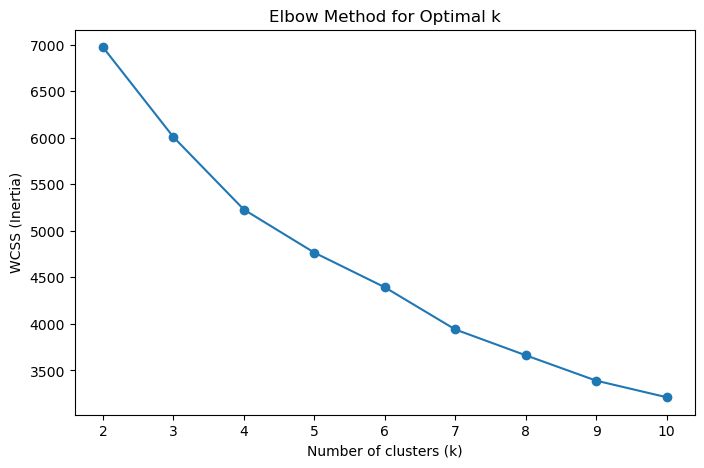

In [44]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

# Range of k to try
K_range = range(2, 11)

wcss = []
for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(df_scaled)
    wcss.append(kmeans.inertia_)

# Plot Elbow
plt.figure(figsize=(8,5))
plt.plot(K_range, wcss, marker='o')
plt.xlabel("Number of clusters (k)")
plt.ylabel("WCSS (Inertia)")
plt.title("Elbow Method for Optimal k")
plt.show()


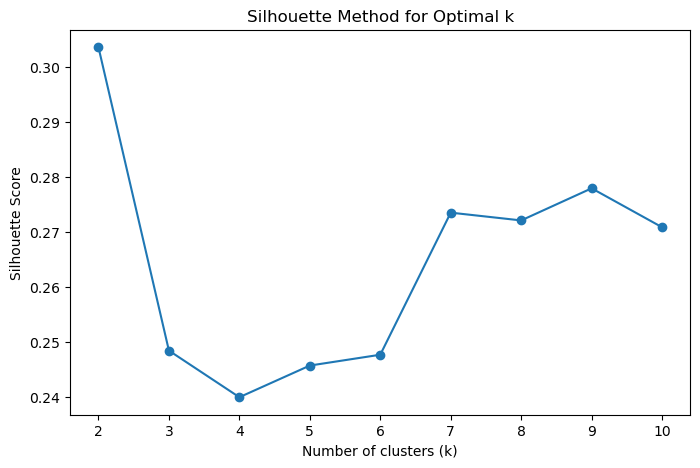

In [45]:
from sklearn.metrics import silhouette_score

sil_scores = []
for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(df_scaled)
    sil = silhouette_score(df_scaled, labels)
    sil_scores.append(sil)

# Plot Silhouette
plt.figure(figsize=(8,5))
plt.plot(K_range, sil_scores, marker='o')
plt.xlabel("Number of clusters (k)")
plt.ylabel("Silhouette Score")
plt.title("Silhouette Method for Optimal k")
plt.show()


## clustering

In [32]:
#for k = 2,3

In [46]:
df_scaled.head()

,BALANCE_FREQUENCY,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PRC_FULL_PAYMENT,TENURE,BALANCE_log,PURCHASES_log,ONEOFF_PURCHASES_log,INSTALLMENTS_PURCHASES_log,CASH_ADVANCE_log,PAYMENTS_log,MINIMUM_PAYMENTS_log
0,0.818182,0.166667,0.000000,0.083333,0.000000,0.00000,0.005587,0.031720,0.000000,1,0.379045,0.422994,0.000000,0.455879,0.000000,0.490324,0.438874
1,0.909091,0.000000,0.000000,0.000000,0.166667,0.03252,0.000000,0.232053,0.222222,1,0.819116,0.000000,0.000000,0.000000,0.815075,0.767919,0.620013
2,1.000000,1.000000,1.000000,0.000000,0.000000,0.00000,0.033520,0.248748,0.000000,1,0.793799,0.615884,0.626611,0.000000,0.000000,0.593925,0.572303
3,0.636364,0.083333,0.083333,0.000000,0.055555,0.00813,0.002793,0.248748,0.000000,1,0.752871,0.677125,0.688918,0.000000,0.495472,0.000000,0.510325
4,1.000000,0.083333,0.083333,0.000000,0.000000,0.00000,0.002793,0.038397,0.000000,1,0.680676,0.262325,0.266894,0.000000,0.000000,0.601905,0.488693


In [47]:
# Use scaled features (exclude any cluster cols if present)
X = df_scaled.drop(columns=[col for col in df_scaled.columns if "Cluster" in col], errors="ignore").values

results = []

# ---------- KMeans ----------
for k in [2, 3]:
    model = KMeans(n_clusters=k, random_state=42)
    labels = model.fit_predict(X)
    sil = silhouette_score(X, labels)
    dbi = davies_bouldin_score(X, labels)
    chi = calinski_harabasz_score(X, labels)
    results.append(("KMeans", k, sil, dbi, chi, model))

# ---------- Gaussian Mixture (GMM) ----------
for k in [2, 3]:
    model = GaussianMixture(n_components=k, random_state=42)
    labels = model.fit_predict(X)
    sil = silhouette_score(X, labels)
    dbi = davies_bouldin_score(X, labels)
    chi = calinski_harabasz_score(X, labels)
    results.append(("GMM", k, sil, dbi, chi, model))

# ---------- Agglomerative ----------
for k in [2, 3]:
    model = AgglomerativeClustering(n_clusters=k)
    labels = model.fit_predict(X)
    sil = silhouette_score(X, labels)
    dbi = davies_bouldin_score(X, labels)
    chi = calinski_harabasz_score(X, labels)
    results.append(("Agglomerative", k, sil, dbi, chi, model))

# ---------- DBSCAN ----------
dbscan = DBSCAN(eps=0.5, min_samples=5)
labels = dbscan.fit_predict(X)

# Only calculate metrics if clusters > 1
if len(set(labels)) > 1 and -1 not in set(labels):
    sil = silhouette_score(X, labels)
    dbi = davies_bouldin_score(X, labels)
    chi = calinski_harabasz_score(X, labels)
    results.append(("DBSCAN", None, sil, dbi, chi, dbscan))
else:
    results.append(("DBSCAN", None, -1, np.inf, -1, dbscan))  # invalid clustering

# ---------- Collect results ----------
df_results = pd.DataFrame(results, columns=["Method", "K", "Silhouette", "DBI", "CHI", "Model"])

print("📊 Clustering Validation Results:")
print(df_results.drop(columns="Model"))

# ---------- Best model ----------
best_idx = df_results["Silhouette"].idxmax()
best_row = df_results.loc[best_idx]

print("\n✅ Best model is: {} (k={}) with Silhouette={:.4f}".format(
    best_row["Method"], best_row["K"], best_row["Silhouette"]
))

best_model = best_row["Model"]


📊 Clustering Validation Results:
          Method    K  Silhouette       DBI          CHI
0         KMeans  2.0    0.303652  1.357558  4430.375131
1         KMeans  3.0    0.248458  1.640776  3288.888206
2            GMM  2.0    0.275193  1.460360  3698.673266
3            GMM  3.0    0.199857  1.912354  2396.370380
4  Agglomerative  2.0    0.273598  1.481680  3672.902687
5  Agglomerative  3.0    0.197094  1.746481  2800.855769
6         DBSCAN  NaN   -1.000000       inf    -1.000000

✅ Best model is: KMeans (k=2.0) with Silhouette=0.3037


In [48]:
#for k=4,5

In [49]:
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score

# Use scaled features (exclude any cluster cols if present)
X = df_scaled.drop(columns=[col for col in df_scaled.columns if "Cluster" in col], errors="ignore").values

results = []

# ---------- KMeans ----------
for k in [4, 5]:
    model = KMeans(n_clusters=k, random_state=42)
    labels = model.fit_predict(X)
    sil = silhouette_score(X, labels)
    dbi = davies_bouldin_score(X, labels)
    chi = calinski_harabasz_score(X, labels)
    results.append(("KMeans", k, sil, dbi, chi, model))

# ---------- Gaussian Mixture (GMM) ----------
for k in [4, 5]:
    model = GaussianMixture(n_components=k, random_state=42)
    labels = model.fit_predict(X)
    sil = silhouette_score(X, labels)
    dbi = davies_bouldin_score(X, labels)
    chi = calinski_harabasz_score(X, labels)
    results.append(("GMM", k, sil, dbi, chi, model))

# ---------- Agglomerative ----------
for k in [4, 5]:
    model = AgglomerativeClustering(n_clusters=k)
    labels = model.fit_predict(X)
    sil = silhouette_score(X, labels)
    dbi = davies_bouldin_score(X, labels)
    chi = calinski_harabasz_score(X, labels)
    results.append(("Agglomerative", k, sil, dbi, chi, model))

# ---------- DBSCAN ----------
dbscan = DBSCAN(eps=0.5, min_samples=5)
labels = dbscan.fit_predict(X)

# Only calculate metrics if clusters > 1
if len(set(labels)) > 1 and -1 not in set(labels):
    sil = silhouette_score(X, labels)
    dbi = davies_bouldin_score(X, labels)
    chi = calinski_harabasz_score(X, labels)
    results.append(("DBSCAN", None, sil, dbi, chi, dbscan))
else:
    results.append(("DBSCAN", None, -1, np.inf, -1, dbscan))  # invalid clustering

# ---------- Collect results ----------
df_results = pd.DataFrame(results, columns=["Method", "K", "Silhouette", "DBI", "CHI", "Model"])

print("📊 Clustering Validation Results:")
print(df_results.drop(columns="Model"))

# ---------- Best model ----------
best_idx = df_results["Silhouette"].idxmax()
best_row = df_results.loc[best_idx]

print("\n✅ Best model is: {} (k={}) with Silhouette={:.4f}".format(
    best_row["Method"], best_row["K"], best_row["Silhouette"]
))

best_model = best_row["Model"]


📊 Clustering Validation Results:
          Method    K  Silhouette       DBI          CHI
0         KMeans  4.0    0.239977  1.584204  2962.977401
1         KMeans  5.0    0.245737  1.463494  2654.620086
2            GMM  4.0    0.226032  1.812881  2294.750559
3            GMM  5.0    0.220819  1.570598  2260.077051
4  Agglomerative  4.0    0.196048  1.779538  2422.807765
5  Agglomerative  5.0    0.219514  1.558067  2322.104580
6         DBSCAN  NaN   -1.000000       inf    -1.000000

✅ Best model is: KMeans (k=5.0) with Silhouette=0.2457


In [50]:
df_scaled.head()

,BALANCE_FREQUENCY,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PRC_FULL_PAYMENT,TENURE,BALANCE_log,PURCHASES_log,ONEOFF_PURCHASES_log,INSTALLMENTS_PURCHASES_log,CASH_ADVANCE_log,PAYMENTS_log,MINIMUM_PAYMENTS_log
0,0.818182,0.166667,0.000000,0.083333,0.000000,0.00000,0.005587,0.031720,0.000000,1,0.379045,0.422994,0.000000,0.455879,0.000000,0.490324,0.438874
1,0.909091,0.000000,0.000000,0.000000,0.166667,0.03252,0.000000,0.232053,0.222222,1,0.819116,0.000000,0.000000,0.000000,0.815075,0.767919,0.620013
2,1.000000,1.000000,1.000000,0.000000,0.000000,0.00000,0.033520,0.248748,0.000000,1,0.793799,0.615884,0.626611,0.000000,0.000000,0.593925,0.572303
3,0.636364,0.083333,0.083333,0.000000,0.055555,0.00813,0.002793,0.248748,0.000000,1,0.752871,0.677125,0.688918,0.000000,0.495472,0.000000,0.510325
4,1.000000,0.083333,0.083333,0.000000,0.000000,0.00000,0.002793,0.038397,0.000000,1,0.680676,0.262325,0.266894,0.000000,0.000000,0.601905,0.488693


In [53]:
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score

# Use scaled features (exclude cluster cols if any)
X = df_scaled.drop(columns=[col for col in df_scaled.columns if "Cluster" in col], errors="ignore").values
n_features = X.shape[1]

results = []
stored_dfs = {}

# Try PCA with valid component counts only
for n_comp in [2, 3, 5, 10, None]:  # None = no PCA (all features)
    if n_comp is not None:
        if n_comp > n_features:
            continue  # skip invalid PCA values
        pca = PCA(n_components=n_comp, random_state=42)
        X_transformed = pca.fit_transform(X)
    else:
        X_transformed = X  # keep all features
    
    # Try KMeans with k=2..5
    for k in [2, 3, 4, 5]:
        kmeans = KMeans(n_clusters=k, random_state=42)
        labels = kmeans.fit_predict(X_transformed)

        sil = silhouette_score(X_transformed, labels)
        dbi = davies_bouldin_score(X_transformed, labels)
        chi = calinski_harabasz_score(X_transformed, labels)

        results.append(("KMeans", k, n_comp if n_comp else "All", sil, dbi, chi))

        # Store the dataframe copy with this clustering
        df_temp = df_scaled.copy()
        df_temp[f"Cluster_KMeans{k}_PCA{n_comp if n_comp else 'All'}"] = labels
        stored_dfs[(k, n_comp)] = (df_temp, kmeans)

# Collect results
df_results = pd.DataFrame(results, columns=["Method", "K", "PCA_Components", "Silhouette", "DBI", "CHI"])
df_results = df_results.sort_values(by="Silhouette", ascending=False)

print("📊 PCA + KMeans Clustering Results (Top 10):")
print(df_results.head(10))

# Pick best model
best_row = df_results.iloc[0]
print(f"\n✅ Best is: {best_row['Method']} (k={best_row['K']}, PCA={best_row['PCA_Components']}) "
      f"with Silhouette={best_row['Silhouette']:.4f}")

# Retrieve corresponding dataframe and model
best_df, best_model = stored_dfs[(best_row["K"], None if best_row["PCA_Components"]=="All" else best_row["PCA_Components"])]


📊 PCA + KMeans Clustering Results (Top 10):
    Method  K PCA_Components  Silhouette       DBI           CHI
0   KMeans  2              2    0.495093  0.780987  12088.553122
1   KMeans  3              2    0.484980  0.802704  11977.908752
2   KMeans  4              2    0.460388  0.758518  12689.343215
3   KMeans  5              2    0.439113  0.838945  11945.695279
4   KMeans  2              3    0.420770  0.982768   8158.848367
7   KMeans  5              3    0.388355  1.028984   6764.205351
6   KMeans  4              3    0.380608  1.029916   6972.380335
5   KMeans  3              3    0.375177  1.129216   6739.744512
8   KMeans  2              5    0.350425  1.197655   5567.622348
11  KMeans  5              5    0.324620  1.189870   3887.668425

✅ Best is: KMeans (k=2, PCA=2) with Silhouette=0.4951


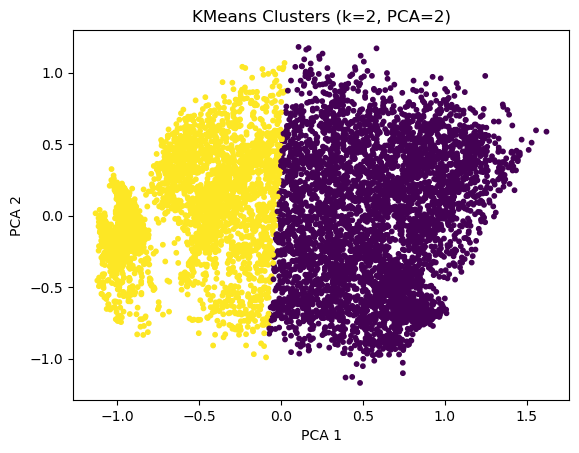

In [54]:
import matplotlib.pyplot as plt

X_pca2 = PCA(n_components=2, random_state=42).fit_transform(X)
labels = stored_dfs[(2, 2)][0]["Cluster_KMeans2_PCA2"]

plt.scatter(X_pca2[:,0], X_pca2[:,1], c=labels, cmap="viridis", s=10)
plt.title("KMeans Clusters (k=2, PCA=2)")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.show()


In [61]:
df_scaled.head()

,BALANCE_FREQUENCY,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PRC_FULL_PAYMENT,TENURE,BALANCE_log,PURCHASES_log,ONEOFF_PURCHASES_log,INSTALLMENTS_PURCHASES_log,CASH_ADVANCE_log,PAYMENTS_log,MINIMUM_PAYMENTS_log
0,0.818182,0.166667,0.000000,0.083333,0.000000,0.00000,0.005587,0.031720,0.000000,1,0.379045,0.422994,0.000000,0.455879,0.000000,0.490324,0.438874
1,0.909091,0.000000,0.000000,0.000000,0.166667,0.03252,0.000000,0.232053,0.222222,1,0.819116,0.000000,0.000000,0.000000,0.815075,0.767919,0.620013
2,1.000000,1.000000,1.000000,0.000000,0.000000,0.00000,0.033520,0.248748,0.000000,1,0.793799,0.615884,0.626611,0.000000,0.000000,0.593925,0.572303
3,0.636364,0.083333,0.083333,0.000000,0.055555,0.00813,0.002793,0.248748,0.000000,1,0.752871,0.677125,0.688918,0.000000,0.495472,0.000000,0.510325
4,1.000000,0.083333,0.083333,0.000000,0.000000,0.00000,0.002793,0.038397,0.000000,1,0.680676,0.262325,0.266894,0.000000,0.000000,0.601905,0.488693


In [62]:
df_scaled.to_csv('C:/Users/Sultan/Downloads/ML/ML_Project/4. Credit Card/csv_files/1_prep_cc.csv')

In [60]:
df_clustered.to_csv('C:/Users/Sultan/Downloads/ML/ML_Project/4. Credit Card/csv_files/2_clustered_cc.csv')

In [3]:
df_scaled = pd.read_csv('C:/Users/Sultan/Downloads/ML/ML_Project/4. Credit Card/csv-files/1_prep_cc.csv')

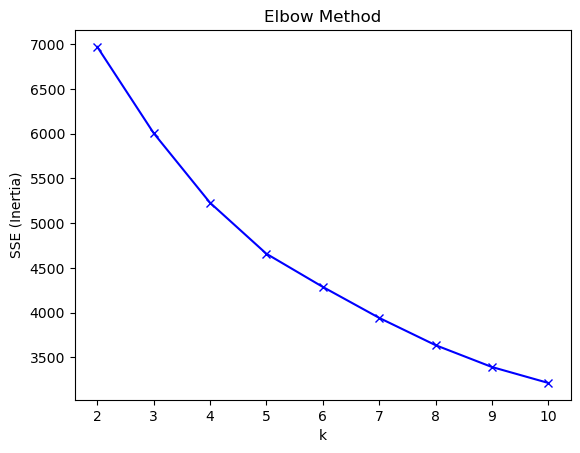

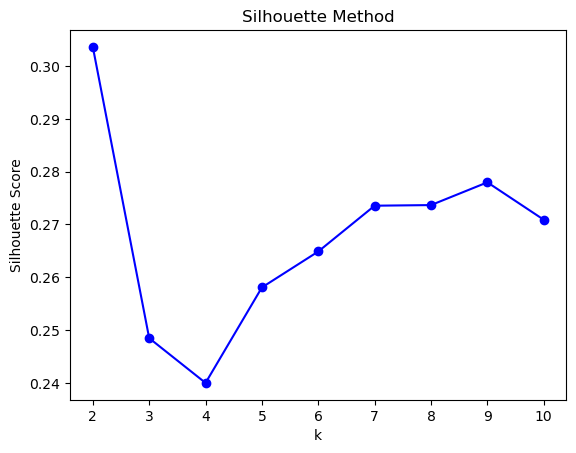

In [30]:
# Try different k values
sse = []
silhouette_scores = []
K = range(2, 11)

for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(df_scaled)
    sse.append(kmeans.inertia_)  # Sum of squared errors
    silhouette_scores.append(silhouette_score(df_scaled, kmeans.labels_))

# Plot elbow method
plt.plot(K, sse, 'bx-')
plt.xlabel('k')
plt.ylabel('SSE (Inertia)')
plt.title('Elbow Method')
plt.show()

# Plot silhouette scores
plt.plot(K, silhouette_scores, 'bo-')
plt.xlabel('k')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Method')
plt.show()


In [31]:
k_values = [4, 5]
results = {}

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    df['Cluster_' + str(k)] = kmeans.fit_predict(df)
    sil_score = silhouette_score(df.drop(columns=['Cluster_' + str(k)]), df['Cluster_' + str(k)])
    results[k] = sil_score
    print(f"K={k}, Silhouette Score={sil_score:.4f}")

# -------------------------------
# Cluster Profiling
# -------------------------------
for k in k_values:
    print("\nCluster Profiles for K =", k)
    cluster_profile = df.groupby('Cluster_' + str(k)).mean()
    print(cluster_profile)

    # Also show cluster sizes
    print("\nCluster Sizes:")
    print(df['Cluster_' + str(k)].value_counts())

K=4, Silhouette Score=0.4673
K=5, Silhouette Score=0.4076

Cluster Profiles for K = 4
               BALANCE  BALANCE_FREQUENCY     PURCHASES  ONEOFF_PURCHASES  \
Cluster_4                                                                   
0          4058.147688           0.988636   1027.378750        118.389464   
1          3317.837007           0.939964   1581.990512        997.420947   
2           853.540399           0.853298    601.418059        310.925820   
3          4792.532971           0.910564  10786.530233       7669.934651   

           INSTALLMENTS_PURCHASES  CASH_ADVANCE  PURCHASES_FREQUENCY  \
Cluster_4                                                              
0                      908.989286    922.757849             0.471320   
1                      584.880443   2102.483759             0.543024   
2                      290.793799    495.224680             0.466551   
3                     3116.766124   5171.008060             0.750458   

           ONEOFF_

In [32]:
kmeans = KMeans(n_clusters=5, random_state=42, n_init=10)
labels = kmeans.fit_predict(df_scaled)

In [33]:
df_scaled['Cluster_5'] = labels   # For scaled data reference
df['Cluster_5'] = labels          # For interpreting clusters in original scale

In [4]:
df_scaled.head()

,Unnamed: 0,BALANCE_FREQUENCY,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PRC_FULL_PAYMENT,TENURE,BALANCE_log,PURCHASES_log,ONEOFF_PURCHASES_log,INSTALLMENTS_PURCHASES_log,CASH_ADVANCE_log,PAYMENTS_log,MINIMUM_PAYMENTS_log
0,0,0.818182,0.166667,0.000000,0.083333,0.000000,0.00000,0.005587,0.031720,0.000000,1,0.379045,0.422994,0.000000,0.455879,0.000000,0.490324,0.438874
1,1,0.909091,0.000000,0.000000,0.000000,0.166667,0.03252,0.000000,0.232053,0.222222,1,0.819116,0.000000,0.000000,0.000000,0.815075,0.767919,0.620013
2,2,1.000000,1.000000,1.000000,0.000000,0.000000,0.00000,0.033520,0.248748,0.000000,1,0.793799,0.615884,0.626611,0.000000,0.000000,0.593925,0.572303
3,3,0.636364,0.083333,0.083333,0.000000,0.055555,0.00813,0.002793,0.248748,0.000000,1,0.752871,0.677125,0.688918,0.000000,0.495472,0.000000,0.510325
4,4,1.000000,0.083333,0.083333,0.000000,0.000000,0.00000,0.002793,0.038397,0.000000,1,0.680676,0.262325,0.266894,0.000000,0.000000,0.601905,0.488693


In [36]:
#Cluster Profiling (Interpretation)
cluster_profile = df_scaled.groupby('Cluster_5').mean()
print(cluster_profile)
print(df_scaled['Cluster_5'].value_counts())

           BALANCE_FREQUENCY  PURCHASES_FREQUENCY  ONEOFF_PURCHASES_FREQUENCY  \
Cluster_5                                                                       
0                   0.752214             0.289863                    0.185877   
1                   0.981678             0.908476                    0.618422   
2                   0.922908             0.038399                    0.022104   
3                   0.886269             0.851302                    0.022855   
4                   0.776978             0.186281                    0.117579   

           PURCHASES_INSTALLMENTS_FREQUENCY  CASH_ADVANCE_FREQUENCY  \
Cluster_5                                                             
0                                  0.105970                0.031656   
1                                  0.644130                0.075177   
2                                  0.014480                0.185705   
3                                  0.810298                0.026572   
4     

<Axes: xlabel='Cluster_5', ylabel='BALANCE'>

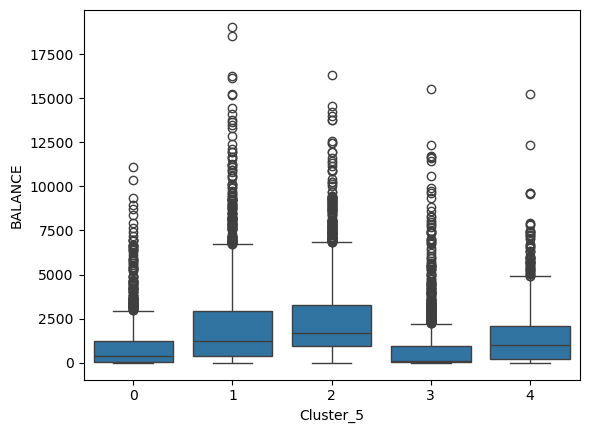

In [37]:
import seaborn as sns
sns.boxplot(x='Cluster_5', y='BALANCE', data=df)

In [38]:
silhouette = silhouette_score(df_scaled.drop(columns=['Cluster_5']), df_scaled['Cluster_5'])
print("Silhouette Score:", silhouette)


Silhouette Score: 0.2580712145624225


In [8]:
# Function to evaluate clustering results
def evaluate_clustering(data, labels, method_name, k):
    sil = silhouette_score(data, labels)
    dbi = davies_bouldin_score(data, labels)
    chi = calinski_harabasz_score(data, labels)
    print(f"\n{method_name} (k={k}):")
    print(f"  Silhouette Score: {sil:.4f}")
    print(f"  Davies-Bouldin Index: {dbi:.4f}")
    print(f"  Calinski-Harabasz Index: {chi:.4f}")
    return labels

# -------------------------------
# KMeans
# -------------------------------
kmeans_4 = KMeans(n_clusters=4, random_state=42)
labels_kmeans_4 = kmeans_4.fit_predict(df_scaled)
df_scaled["cluster_kmeans_4"] = labels_kmeans_4
evaluate_clustering(df_scaled.drop(columns=["cluster_kmeans_4"]), labels_kmeans_4, "KMeans", 4)

kmeans_5 = KMeans(n_clusters=5, random_state=42)
labels_kmeans_5 = kmeans_5.fit_predict(df_scaled)
df_scaled["cluster_kmeans_5"] = labels_kmeans_5
evaluate_clustering(df_scaled.drop(columns=["cluster_kmeans_5"]), labels_kmeans_5, "KMeans", 5)

# -------------------------------
# KMedoids
# -------------------------------
kmedoids_4 = KMedoids(n_clusters=4, random_state=42, metric="euclidean")
labels_kmedoids_4 = kmedoids_4.fit_predict(df_scaled)
df_scaled["cluster_kmedoids_4"] = labels_kmedoids_4
evaluate_clustering(df_scaled.drop(columns=["cluster_kmedoids_4"]), labels_kmedoids_4, "KMedoids", 4)

kmedoids_5 = KMedoids(n_clusters=5, random_state=42, metric="euclidean")
labels_kmedoids_5 = kmedoids_5.fit_predict(df_scaled)
df_scaled["cluster_kmedoids_5"] = labels_kmedoids_5
evaluate_clustering(df_scaled.drop(columns=["cluster_kmedoids_5"]), labels_kmedoids_5, "KMedoids", 5)


KMeans (k=4):
  Silhouette Score: 0.5717
  Davies-Bouldin Index: 0.5000
  Calinski-Harabasz Index: 44726.5632

KMeans (k=5):
  Silhouette Score: 0.5607
  Davies-Bouldin Index: 0.5000
  Calinski-Harabasz Index: 53659.9246


NameError: name 'KMedoids' is not defined

In [9]:


results = []
data = df_scaled.values

# --- KMeans (deterministic with random_state) ---
for k in [4, 5]:
    kmeans = KMeans(n_clusters=k, random_state=42).fit(data)
    labels = kmeans.labels_

    sil = silhouette_score(data, labels)
    dbi = davies_bouldin_score(data, labels)
    chi = calinski_harabasz_score(data, labels)

    results.append(["KMeans", k, sil, dbi, chi])

# --- KMedoids (multiple runs for stability) ---
for k in [4, 5]:
    sil_scores, dbi_scores, chi_scores = [], [], []
    
    for _ in range(5):  # repeat 5 times
        initial_medoids = np.random.choice(len(data), k, replace=False).tolist()
        kmedoids_instance = kmedoids(data, initial_medoids, data_type='points')
        kmedoids_instance.process()

        clusters = kmedoids_instance.get_clusters()
        labels = np.zeros(len(data))

        for cluster_id, cluster_indices in enumerate(clusters):
            for idx in cluster_indices:
                labels[idx] = cluster_id

        sil_scores.append(silhouette_score(data, labels))
        dbi_scores.append(davies_bouldin_score(data, labels))
        chi_scores.append(calinski_harabasz_score(data, labels))

    # Take average of runs
    results.append([
        "KMedoids", k,
        np.mean(sil_scores),
        np.mean(dbi_scores),
        np.mean(chi_scores)
    ])

# Results DataFrame
results_df = pd.DataFrame(results, columns=["Method", "K", "Silhouette", "DBI", "CHI"])

print("\n📊 Clustering Validation Results (Averaged for KMedoids):\n")
print(results_df.to_string(index=False))



📊 Clustering Validation Results (Averaged for KMedoids):

  Method  K  Silhouette      DBI          CHI
  KMeans  4    0.571733 0.500008 44726.378283
  KMeans  5    0.560717 0.500008 53661.072401
KMedoids  4    0.571738 0.500009 44729.675748
KMedoids  5    0.560723 0.500008 53669.528832


In [10]:
import numpy as np
import pandas as pd
from sklearn.mixture import GaussianMixture
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
import joblib  # for saving best model

results = []
data = df_scaled.values
best_model = None
best_score = -1
best_desc = ""

# --- Gaussian Mixture Models (GMM) ---
for k in [4, 5]:
    gmm = GaussianMixture(n_components=k, random_state=42)
    labels = gmm.fit_predict(data)

    sil = silhouette_score(data, labels)
    dbi = davies_bouldin_score(data, labels)
    chi = calinski_harabasz_score(data, labels)

    results.append([f"GMM (k={k})", sil, dbi, chi])

    # Track best model
    if sil > best_score:
        best_score = sil
        best_model = gmm
        best_desc = f"GMM (k={k})"

# --- DBSCAN ---
# Try different eps values (tuneable hyperparameter)
for eps in [0.3, 0.5, 0.7]:
    dbscan = DBSCAN(eps=eps, min_samples=5)
    labels = dbscan.fit_predict(data)

    # DBSCAN sometimes assigns -1 for noise, skip if all points are noise
    if len(set(labels)) > 1 and len(set(labels)) < len(data):
        sil = silhouette_score(data, labels)
        dbi = davies_bouldin_score(data, labels)
        chi = calinski_harabasz_score(data, labels)

        results.append([f"DBSCAN (eps={eps})", sil, dbi, chi])

        # Track best model
        if sil > best_score:
            best_score = sil
            best_model = dbscan
            best_desc = f"DBSCAN (eps={eps})"

# --- Results Table ---
results_df = pd.DataFrame(results, columns=["Method", "Silhouette", "DBI", "CHI"])
print("\n📊 Clustering Validation Results:\n")
print(results_df.to_string(index=False))

# --- Save best model ---
print(f"\n✅ Best model is: {best_desc} with Silhouette={best_score:.4f}")
#joblib.dump(best_model, "best_clustering_model.pkl")
#print("💾 Model saved as 'best_clustering_model.pkl'")



📊 Clustering Validation Results:

   Method  Silhouette      DBI          CHI
GMM (k=4)    0.571733 0.500008 44726.378283
GMM (k=5)    0.560722 0.500008 53659.941312

✅ Best model is: GMM (k=4) with Silhouette=0.5717


In [19]:
df_scaled= df_scaled.loc[:, ~df_scaled.columns.str.contains('^Unnamed')]

In [20]:
df_scaled = df_scaled.drop(columns=["cluster_kmeans_4", "cluster_kmeans_5"])

In [23]:
df_scaled = df_scaled.drop(columns=["Cluster_KMeans4"])

In [24]:
df_scaled.head()

,BALANCE_FREQUENCY,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PRC_FULL_PAYMENT,TENURE,BALANCE_log,PURCHASES_log,ONEOFF_PURCHASES_log,INSTALLMENTS_PURCHASES_log,CASH_ADVANCE_log,PAYMENTS_log,MINIMUM_PAYMENTS_log
0,0.818182,0.166667,0.000000,0.083333,0.000000,0.00000,0.005587,0.031720,0.000000,1,0.379045,0.422994,0.000000,0.455879,0.000000,0.490324,0.438874
1,0.909091,0.000000,0.000000,0.000000,0.166667,0.03252,0.000000,0.232053,0.222222,1,0.819116,0.000000,0.000000,0.000000,0.815075,0.767919,0.620013
2,1.000000,1.000000,1.000000,0.000000,0.000000,0.00000,0.033520,0.248748,0.000000,1,0.793799,0.615884,0.626611,0.000000,0.000000,0.593925,0.572303
3,0.636364,0.083333,0.083333,0.000000,0.055555,0.00813,0.002793,0.248748,0.000000,1,0.752871,0.677125,0.688918,0.000000,0.495472,0.000000,0.510325
4,1.000000,0.083333,0.083333,0.000000,0.000000,0.00000,0.002793,0.038397,0.000000,1,0.680676,0.262325,0.266894,0.000000,0.000000,0.601905,0.488693


In [27]:
df_scaled.to_csv('C:/Users/Sultan/Downloads/ML/ML_Project/4. Credit Card/csv_files/1_prep_cc.csv')

In [ ]:
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.mixture import GaussianMixture
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score

X = df_scaled.drop(columns=[col for col in df_scaled.columns if "Cluster" in col], errors="ignore").values

results = []
stored_models = {}  # to keep the best model for later use

# PCA dimensions to test
pca_dims = [2, 3, 5]
cluster_range = [2, 3, 4, 5]

for n_comp in pca_dims:
    pca = PCA(n_components=n_comp, random_state=42)
    X_pca = pca.fit_transform(X)

    for k in cluster_range:
        # ---------- KMeans ----------
        kmeans = KMeans(n_clusters=k, random_state=42)
        labels = kmeans.fit_predict(X_pca)
        sil = silhouette_score(X_pca, labels)
        dbi = davies_bouldin_score(X_pca, labels)
        chi = calinski_harabasz_score(X_pca, labels)
        results.append(("KMeans", k, n_comp, sil, dbi, chi))
        stored_models[("KMeans", k, n_comp)] = kmeans

        # ---------- GMM ----------
        gmm = GaussianMixture(n_components=k, random_state=42)
        labels = gmm.fit_predict(X_pca)
        sil = silhouette_score(X_pca, labels)
        dbi = davies_bouldin_score(X_pca, labels)
        chi = calinski_harabasz_score(X_pca, labels)
        results.append(("GMM", k, n_comp, sil, dbi, chi))
        stored_models[("GMM", k, n_comp)] = gmm

        # ---------- Agglomerative ----------
        agg = AgglomerativeClustering(n_clusters=k)
        labels = agg.fit_predict(X_pca)
        sil = silhouette_score(X_pca, labels)
        dbi = davies_bouldin_score(X_pca, labels)
        chi = calinski_harabasz_score(X_pca, labels)
        results.append(("Agglomerative", k, n_comp, sil, dbi, chi))
        stored_models[("Agglomerative", k, n_comp)] = agg

# Collect results
df_results = pd.DataFrame(results, columns=["Method", "K", "PCA_Components", "Silhouette", "DBI", "CHI"])

print("📊 PCA + Clustering Results (Top 10):")
print(df_results.sort_values(by="Silhouette", ascending=False).head(10))

# Best model
best_idx = df_results["Silhouette"].idxmax()
best_row = df_results.loc[best_idx]
print(f"\n✅ Best is: {best_row['Method']} (k={best_row['K']}, PCA={best_row['PCA_Components']}) "
      f"with Silhouette={best_row['Silhouette']:.4f}")

best_model = stored_models[(best_row['Method'], best_row['K'], best_row['PCA_Components'])]


In [ ]:
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import pandas as pd
import joblib

# --- Step 1: Run PCA (2 components) ---
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(df_scaled)

# --- Step 2: Fit Best Model (KMeans k=2) ---
kmeans = KMeans(n_clusters=2, random_state=42)
labels = kmeans.fit_predict(X_pca)

# --- Step 3: Store labels in a copy (not changing original df) ---
df_clustered = df_scaled.copy()
df_clustered["Cluster"] = labels

# --- Step 4: Save model + PCA transformer ---
joblib.dump(kmeans, "best_kmeans_model.pkl")
joblib.dump(pca, "pca_transformer.pkl")

# --- Step 5: Compare averages of original features by cluster ---
cluster_profile = df_clustered.groupby("Cluster").mean()

# --- Step 6: Also include counts ---
cluster_counts = df_clustered["Cluster"].value_counts().rename("Count")
cluster_summary = cluster_profile.join(cluster_counts)

# Show results
print("\n📊 Cluster Profiles (averages + counts):")
print(cluster_summary)
